# Bayesian estimation of the bivariate beta parameter

In [120]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.CRITICAL)

import os
import tqdm
import numpy as np
from scipy import stats
import pandas as pd

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
plt.style.use('science')

import sys
sys.path.append('../scripts/python')
    
from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [3]:
stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v1.stan')
model1 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS':True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v2.stan')
model2 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3.stan')
model3 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

## Default hyperparameters

Generating the data

In [4]:
def generate_data(true_alpha, n, seed):
    ro = np.random.RandomState(seed=seed)
    U = ro.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    return XY, U

## Simulated-based calibration

https://arxiv.org/pdf/1804.06788.pdf

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

Consider the prior $\alpha \sim \operatorname{Gamma}(a=2, b=2)$

In [79]:
a, b = 1, 1

# Gamma hyperparameters
a = a*np.ones(4)
b = b*np.ones(4)
c = 0.0

n = 50

data = {'n': n, 'prior_alpha': 1, 'a': a, 'b': b, 'c': c}

L = 63
N = 1000

Let's see the distribution of $\rho = \#\{\alpha_1 < \hat{\alpha}_1\}$.

In [80]:
rho_values = []
rng = np.random.RandomState(831290)

for _ in tqdm.trange(N):
    true_alpha = rng.gamma(shape=a, scale=1/b, size=4) + c
    seed=rng.randint(831290)
    XY, U = generate_data(true_alpha, n, seed=seed)
    if U[U<=np.finfo(np.float64).eps].shape[0] > 0:
        continue
    data['xy'] = XY
    model_fit = model3.sample(data=data, iter_warmup=1000, iter_sampling=1000, chains=1, adapt_delta=0.9,
                              show_progress=False, show_console=False)
    alpha_estimates = (model_fit.stan_variables()['alpha'])[rng.choice(range(1000), size=L, replace=False)]
    rho = np.sum(alpha_estimates > true_alpha, axis=0)
    rho_values.append({'rho': rho, 
                       'diagnose': model_fit.diagnose(),
                       'true_alpha': true_alpha, 
                       'seed': seed,
                       'XY': XY,
                       'U': U})

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]10:18:02 - cmdstanpy - INFO - CmdStan start processing
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
10:18:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:18:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 307 divergent transitions (30.7%)
	Use function "diagnose()" to see further information.
  0%|                                                                                  | 1/1000 [00:01<24:21,  1.46s/it]10:18:03 - cmdstanpy - INFO - CmdStan start processing
10:18:03 - 

  1%|█                                                                              | 13/1000 [00:32<1:12:29,  4.41s/it]10:18:34 - cmdstanpy - INFO - CmdStan start processing
10:18:34 - cmdstanpy - INFO - Chain [1] start processing
10:18:38 - cmdstanpy - INFO - Chain [1] done processing
10:18:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:18:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 930 divergent transitions (93.0%)
	Use function "diagnose()" to see further information.
  1%|█                                                                              | 14/1000 [00:36<1:11:00,  4.32s/it]10:18:38 - cmdstanpy - INFO - CmdStan start processing
10:18:38 - 

10:19:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.
  4%|██▉                                                                              | 37/1000 [01:27<36:09,  2.25s/it]10:19:29 - cmdstanpy - INFO - CmdStan start processing
10:19:29 - cmdstanpy - INFO - Chain [1] start processing
10:19:30 - cmdstanpy - INFO - Chain [1] done processing
10:19:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:19:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 79 divergent transitions (7.9%)
	Use function "diagnose()" to see further information.
  4%|███       

  6%|█████                                                                            | 62/1000 [01:50<16:00,  1.02s/it]10:19:52 - cmdstanpy - INFO - CmdStan start processing
10:19:52 - cmdstanpy - INFO - Chain [1] start processing
10:19:53 - cmdstanpy - INFO - Chain [1] done processing
10:19:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 187 divergent transitions (18.7%)
	Use function "diagnose()" to see further information.
  6%|█████                                                                            | 63/1000 [01:51<15:54,  1.02s/it]10:19:53 - cmdstanpy - INFO - CmdStan start processing
10:19:53 - cmdstanpy - INFO - Chain [1] start processing
10:19:53 - cmdstanpy - INFO - Chain [1] done processing
10:19:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[2] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 

10:20:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
  7%|█████▉                                                                           | 74/1000 [02:04<20:27,  1.33s/it]10:20:06 - cmdstanpy - INFO - CmdStan start processing
10:20:06 - cmdstanpy - INFO - Chain [1] start processing
10:20:07 - cmdstanpy - INFO - Chain [1] done processing
10:20:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 276 divergent transitions (27.6%)
	Use function "diagnose()" to see further information.
  8%|██████                                                                           | 75/1000 [02:05<20:49,  1.35s/it]10:20:08 - cmdstanpy - INFO - CmdStan start processing
10:20:08 - 

  9%|███████▏                                                                         | 88/1000 [02:22<20:27,  1.35s/it]10:20:24 - cmdstanpy - INFO - CmdStan start processing
10:20:24 - cmdstanpy - INFO - Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
10:20:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:20:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 231 divergent transitions (23.1%)
	Use function "diagnose()" to see further information.
  9%|███████▏                                                                         | 89/1000 [02:23<18:48,  1.24s/it]10:20:25 - cmdstanpy - INFO - CmdStan start processing
10:20:25 - 

10:20:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.
 10%|████████                                                                         | 99/1000 [02:41<21:57,  1.46s/it]10:20:43 - cmdstanpy - INFO - CmdStan start processing
10:20:43 - cmdstanpy - INFO - Chain [1] start processing
10:20:44 - cmdstanpy - INFO - Chain [1] done processing
10:20:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 41 divergent transitions (4.1%)
	Use function "diagnose()" to see further information.
 10%|████████                                                                        | 100/1000 [02:42<19:43,  1.31s/it]10:20:44 - cmdstanpy - INFO - CmdStan start processing
10:20:44 - cmdstanpy - INFO - Chain [1] start processing
10:20:44 - cmdstanpy - INFO - Chain [1] done processing
10:20:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Ch

10:20:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 694 divergent transitions (69.4%)
	Chain 1 had 7 iterations at max treedepth (0.7%)
	Use function "diagnose()" to see further information.
 11%|████████▉                                                                       | 112/1000 [02:56<28:23,  1.92s/it]10:20:58 - cmdstanpy - INFO - CmdStan start processing
10:20:58 - cmdstanpy - INFO - Chain [1] start processing
10:20:58 - cmdstanpy - INFO - Chain [1] done processing
10:20:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
 11%|█████████                                                                       | 113/1000 [02:56<22:46,  1.54s/it]10:20:59 - cmdstanpy - INFO - CmdStan start processing
10:20:59 - cmdstanpy - INFO - Chain [1] start processing
10:21:00 - cmdstanpy - INFO - Chain [1] done processing
10:21:00 - cmdstanpy - WA

10:21:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 732 divergent transitions (73.2%)
	Chain 1 had 268 iterations at max treedepth (26.8%)
	Use function "diagnose()" to see further information.
 13%|██████████                                                                      | 126/1000 [03:20<51:31,  3.54s/it]10:21:22 - cmdstanpy - INFO - CmdStan start processing
10:21:22 - cmdstanpy - INFO - Chain [1] start processing
10:21:31 - cmdstanpy - INFO - Chain [1] done processing
10:21:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:21:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 172 divergent transitions (17.2%)
	Chain 1 had

 14%|███████████                                                                     | 139/1000 [03:39<10:58,  1.31it/s]10:21:41 - cmdstanpy - INFO - CmdStan start processing
10:21:41 - cmdstanpy - INFO - Chain [1] start processing
10:21:42 - cmdstanpy - INFO - Chain [1] done processing
10:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
 14%|███████████▏                                                                    | 140/1000 [03:40<10:03,  1.43it/s]10:21:42 - cmdstanpy - INFO - CmdStan start processing
10:21:42 - cmdstanpy - INFO - Chain [1] start processing
10:21:43 - cmdstanpy - INFO - Chain [1] done processing
10:21:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exceptio

10:21:54 - cmdstanpy - INFO - Chain [1] done processing
10:21:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:21:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 212 divergent transitions (21.2%)
	Use function "diagnose()" to see further information.
 15%|████████████▏                                                                   | 152/1000 [03:52<11:31,  1.23it/s]10:21:54 - cmdstanpy - INFO - CmdStan start processing
10:21:54 - cmdstanpy - INFO - Chain [1] start processing
10:21:55 - cmdstanpy - INFO - Chain [1] done processing
10:21:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be po

10:22:14 - cmdstanpy - INFO - Chain [1] done processing
10:22:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 158 divergent transitions (15.8%)
	Use function "diagnose()" to see further information.
 16%|█████████████▏                                                                  | 165/1000 [04:12<18:03,  1.30s/it]10:22:14 - cmdstanpy - INFO - CmdStan start processing
10:22:14 - cmdstanpy - INFO - Chain [1] start processing
10:22:23 - cmdstanpy - INFO - Chain [1] done processing
10:22:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
10:22:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 578 divergent transitions (57.8%)
	Chain 1 

10:22:33 - cmdstanpy - INFO - Chain [1] start processing
10:22:33 - cmdstanpy - INFO - Chain [1] done processing
 18%|██████████████▎                                                                 | 179/1000 [04:31<12:50,  1.06it/s]10:22:33 - cmdstanpy - INFO - CmdStan start processing
10:22:33 - cmdstanpy - INFO - Chain [1] start processing
10:22:34 - cmdstanpy - INFO - Chain [1] done processing
10:22:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
 18%|██████████████▍                                                                 | 180/1000 [04:32<11:39,  1.17it/s]10:22:34 - cmdstanpy - INFO - CmdStan start processing
10:22:34 - cmdstanpy - INFO - Chain [1] start processing
10:22:34 - cmds

 19%|███████████████▎                                                                | 191/1000 [04:43<14:11,  1.05s/it]10:22:45 - cmdstanpy - INFO - CmdStan start processing
10:22:45 - cmdstanpy - INFO - Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1] done processing
10:22:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[2] is inf, but must be positive finite! (in '/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3.stan', line 41, column 4 to column 24)
Consider re-running with show_console=True if the above output is unclear!
 19%|███████████████▎                                                                | 192/1000 [04:44<12:20,  1.09it/s]10:22:46 - cmdstanpy - INFO - CmdStan start processing
10:22:46 - cmdstanpy - INFO - Chain [1] start processing
10:22:47 - cmdstanpy - INFO - Chain [1] done processing
10:22:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Except

RuntimeError: Error during sampling:

Command and output files:
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3', 'id=1', 'random', 'seed=86517', 'data', 'file=/tmp/tmpjhz88wya/_ffgefbi.json', 'output', 'file=/tmp/tmpjhz88wya/bivariate-beta-model-v3e479xo_h/bivariate-beta-model-v3-20220916102313.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpjhz88wya/bivariate-beta-model-v3e479xo_h/bivariate-beta-model-v3-20220916102313.csv
 console_msgs (if any):
	/tmp/tmpjhz88wya/bivariate-beta-model-v3e479xo_h/bivariate-beta-model-v3-20220916102313_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

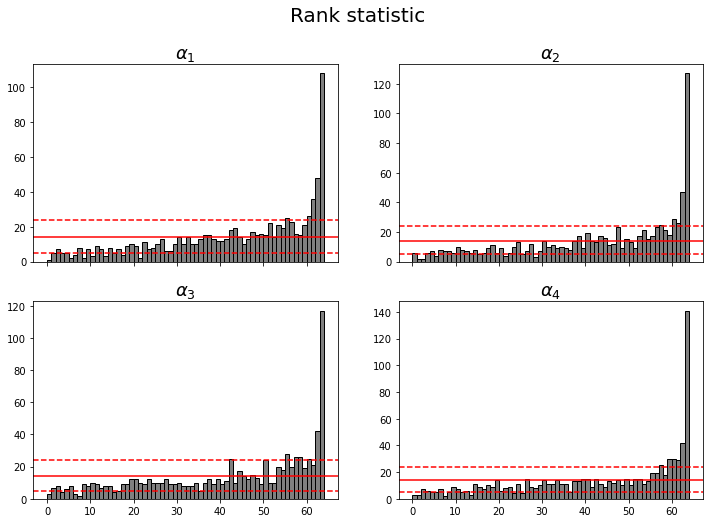

In [9]:
fig, ax = plt.subplots(2,2,figsize=(12,8), sharex=True)

for i in range(4):
    ax[i//2,i%2].hist(np.array([i['rho'] for i in rho_values])[:,i], color='grey', edgecolor='black', bins=range(L+2))
    ax[i//2,i%2].set_title(r'$\alpha_{}$'.format(i+1), fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].axhline(stats.binom(n=len(rho_values), p=1/(L+1)).ppf(0.005), color='red', linestyle='--')
        ax[i,j].axhline(stats.binom(n=len(rho_values), p=1/(L+1)).ppf(0.5), color='red', linestyle='-')
        ax[i,j].axhline(stats.binom(n=len(rho_values), p=1/(L+1)).ppf(0.995), color='red', linestyle='--')
    
fig.suptitle('Rank statistic', fontsize=20)
plt.show()

In [137]:
for i in rho_values:
    txt = "\n\nChecking sampler transitions for divergences.\n"
    diagnose = i['diagnose']
    pos = diagnose.find(txt)
    divergences = diagnose[pos+len(txt):].split()[0]
    if divergences == 'No':
        divergences = 0
    else:
        divergences = int(divergences)
    i['divergences'] = divergences
    
values = np.zeros((len(rho_values), 2))
for i in range(len(rho_values)):
    values[i,0] = min(rho_values[i]['true_alpha'])
    values[i,1] = rho_values[i]['divergences']

Text(0, 0.5, 'Number of divergences')

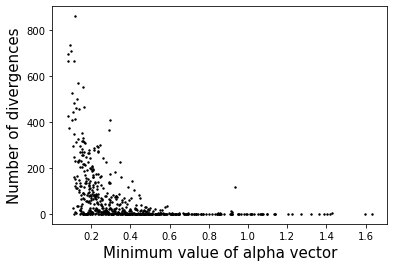

In [138]:
plt.scatter(values[:,0], values[:,1], s=2, color='black')
plt.xlabel('Minimum value of alpha vector', fontsize=15)
plt.ylabel('Number of divergences', fontsize=15)

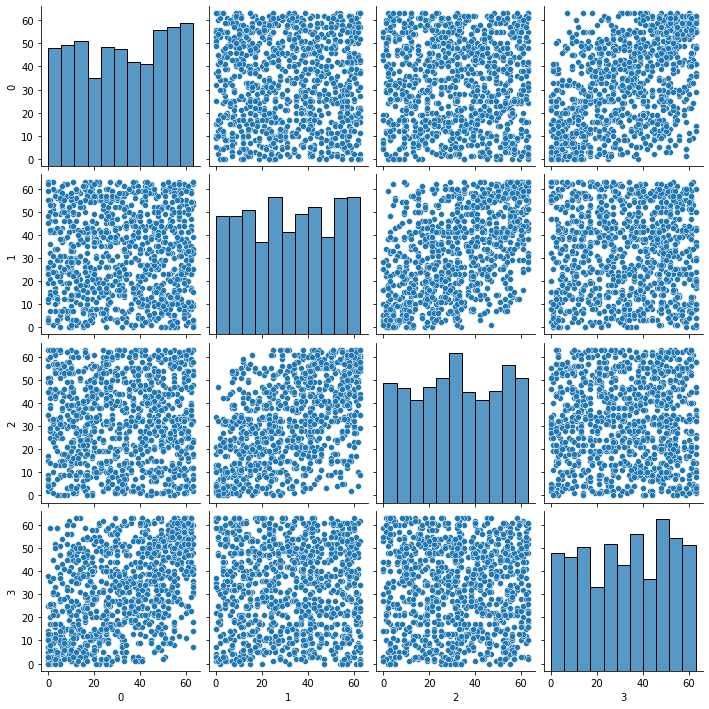

In [23]:
sns.pairplot(data=pd.DataFrame(np.array([i['rho'] for i in rho_values])))

## Posterior-predictive checks

In [182]:
true_alpha = np.array([2,3,0.7,1])
n = 50
seed = 93021421

XY, U = generate_data(true_alpha, n, seed)

a = 1*np.ones(4)
b = 1*np.ones(4)

data = {'n': n, 'a': a, 'b': b, 'xy': XY}

model_fit = model3.sample(data=data, iter_warmup=2000, iter_sampling=2000, chains=4, adapt_delta=0.92)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [183]:
print(model_fit.diagnose())

Processing csv files: /tmp/tmp9o5_og6a/bivariate-beta-model-v394h8l0g8/bivariate-beta-model-v3-20220919182601_1.csv, /tmp/tmp9o5_og6a/bivariate-beta-model-v394h8l0g8/bivariate-beta-model-v3-20220919182601_2.csv, /tmp/tmp9o5_og6a/bivariate-beta-model-v394h8l0g8/bivariate-beta-model-v3-20220919182601_3.csv, /tmp/tmp9o5_og6a/bivariate-beta-model-v394h8l0g8/bivariate-beta-model-v3-20220919182601_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 8000 (0.01%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [184]:
model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,15.823700,0.271447,8.937800,0.361436,16.502800,29.329400,1084.15,447.997,1.00598
alpha[1],1.804410,0.006435,0.317024,1.314040,1.787810,2.350550,2426.99,1002.890,1.00106
alpha[2],2.522070,0.008224,0.411373,1.880150,2.507140,3.223590,2502.40,1034.050,1.00204
alpha[3],0.734841,0.006083,0.193412,0.427217,0.726525,1.065510,1011.04,417.784,1.00417
alpha[4],0.855316,0.005812,0.206566,0.536825,0.844642,1.221220,1263.35,522.044,1.00205
...,...,...,...,...,...,...,...,...,...
u[46],0.101388,0.000531,0.039180,0.027278,0.109874,0.149138,5439.04,2247.540,1.00043
u[47],0.249188,0.001245,0.078204,0.121311,0.255648,0.360102,3945.11,1630.210,1.00013
u[48],0.547287,0.000242,0.016878,0.521062,0.547782,0.571479,4875.43,2014.640,1.00037
u[49],0.267853,0.001279,0.078650,0.141645,0.272245,0.379164,3780.53,1562.200,1.00078


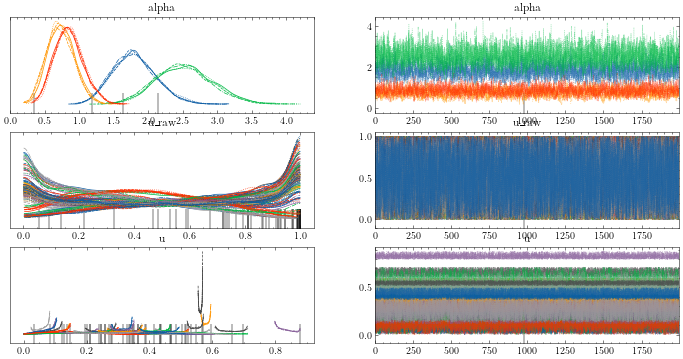

In [185]:
az.plot_trace(model_fit)
plt.show()

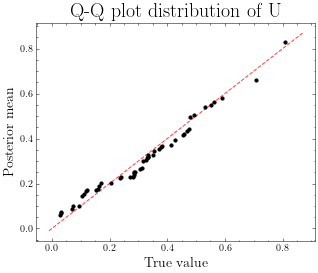

In [186]:
u_true = U[:,0]
u_fitted = model_fit.stan_variables()['u'].mean(axis=0)

fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(np.sort(u_true), np.sort(u_fitted), s=10, color='black')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_xlabel('True value', fontsize=14)
ax.set_ylabel('Posterior mean', fontsize=14)
ax.set_title('Q-Q plot distribution of U', fontsize=20)
plt.show()

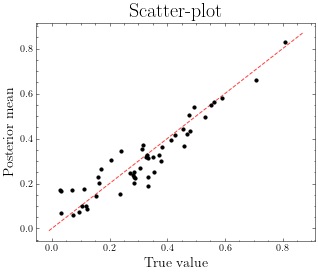

In [187]:
u_true = U[:,0]
u_fitted = np.mean(model_fit.stan_variables()['u'], axis=0)

fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(u_true, u_fitted, s=10, color='black')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_xlabel('True value', fontsize=14)
ax.set_ylabel('Posterior mean', fontsize=14)
ax.set_title('Scatter-plot', fontsize=20)
plt.show()

In [188]:
observed_moments = [XY[:,0].mean(), XY[:,1].mean(), 
                    XY[:,0].var(ddof=1), XY[:,1].var(ddof=1), np.corrcoef(XY[:,0], XY[:,1])[1,0]]

posterior_alpha = model_fit.stan_variables()['alpha']

moments_samples = np.zeros((posterior_alpha.shape[0], 5))

for i, alpha in enumerate(posterior_alpha):
    moments_samples[i] = BivariateBeta().moments(alpha)

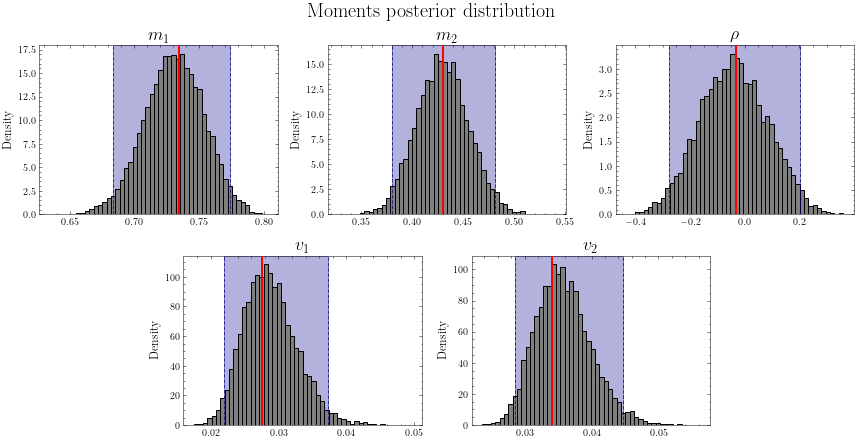

In [190]:
fig = plt.figure(figsize=(12,6))

ax = [plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig),
      plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig),
      plt.subplot2grid((2,6), (1,1), colspan=2, fig=fig),
      plt.subplot2grid((2,6), (1,3), colspan=2, fig=fig),
      plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)]

for i in range(5):
    ax[i].hist(moments_samples[:,i], color='grey', edgecolor='black', bins=50, density=True, zorder=2)
    ax[i].axvline(observed_moments[i], color='red', linestyle='-', zorder=3, linewidth=2)
    ax[i].axvline(np.quantile(moments_samples[:,i], q=0.025), color='darkblue', linestyle='--', zorder=3, alpha=0.7)
    ax[i].axvline(np.quantile(moments_samples[:,i], q=0.975), color='darkblue', linestyle='--', zorder=3, alpha=0.7)
    ax[i].axvspan(np.quantile(moments_samples[:,i], q=0.025), 
                  np.quantile(moments_samples[:,i], q=0.975), 
                  zorder=1, 
                  color='darkblue', alpha=0.3)
    ax[i].set_title([r'$m_1$', r'$m_2$', r'$v_1$', r'$v_2$', r'$\rho$'][i], fontsize=18)
    ax[i].set_ylabel('Density', fontsize=12)
    
fig.tight_layout()
fig.suptitle('Moments posterior distribution', fontsize=20, y=1.03)
plt.savefig('../figures/posterior_moments_distribution.pdf', bbox_inches='tight')